In [60]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.nonparametric.smoothers_lowess import lowess
import pmdarima as pm


import plotly.offline as py
from plotly import tools
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore") 

## Preprocessing data sources

#### Temperature anomaly: NASA GISTEMP Global Means (Land-Ocean Temperature Index, LOTI)

In [2]:
glb = pd.read_csv('weather_data/GLB.Ts+dSST.csv', skiprows=1)
glb = glb[0:139]
glb.tail()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
134,2014,0.72,.51,.75,.76,.85,.66,.55,.80,.88,.80,.65,.77,.73,.72,.63,.79,.67,.78
135,2015,0.81,.86,.89,.74,.75,.78,.71,.78,.81,1.06,1.02,1.10,.86,.83,.81,.79,.76,.97
136,2016,1.15,1.33,1.30,1.07,.90,.77,.81,1.00,.87,.89,.90,.83,.98,1.01,1.19,1.09,.86,.89
137,2017,0.97,1.12,1.12,.92,.88,.69,.82,.86,.75,.87,.85,.89,.90,.89,.97,.97,.79,.83
138,2018,0.77,.84,.91,.87,.81,.74,.78,.73,.75,.99,.78,.89,.82,.82,.83,.86,.75,.84


In [3]:
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb = preprocess_temp_anomaly(glb)
glb['anomaly'] = pd.to_numeric(glb.anomaly)
glb.head()

,anomaly
DateTime,
1880-01-01,-0.29
1880-02-01,-0.18
1880-03-01,-0.11
1880-04-01,-0.19
1880-05-01,-0.11


#### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [4]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

co2 = pd.read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

co2['DateTime']  = pd.to_datetime(co2.Year.map(str) + '-' + co2.Month.map(str))
co2 = co2.set_index(['DateTime'])

co2.replace(to_replace=[-99.99], value=np.nan, inplace=True)
co2.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,NaN,NaN,NaN,NaN,NaN,NaN
1958-02-01,1958,2,21231,1958.1260,NaN,NaN,NaN,NaN,NaN,NaN
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


#### The Oceanic Niño Index (ONI) 

In [5]:
oni = pd.read_csv('weather_data/ONIindex.csv',delim_whitespace=True)
oni['DateTime'] = pd.to_datetime(oni.YR.map(str) + '-' + oni.MON.map(str))
oni = oni.set_index(['DateTime']) 
oni.head()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


#### Sunspot Number

In [6]:
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = pd.read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))
sunspots = sunspots.set_index(['DateTime'])
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


#### Range there is data of all the variables and choose the monthly variables

In [7]:
#Choosing a range there is data of
glb_range = glb['1960-01-01' : '2018-12-01']
co2_range = co2[['CO2filled']]['1960-01-01' : '2018-12-01']  
oni_range = oni[['ANOM']]['1960-01-01' : '2018-12-01']
sunspots_range = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

## Excersise 1

In [114]:
trace1 = go.Scatter(
  x=glb_range.index,
  y=glb_range.anomaly,
  name='Temperature anomaly °C',
  fill='tozeroy'
)
trace2 = go.Scatter(
  x=co2_range.index,
  y=co2_range.CO2filled,
  name='CO2 Concentration ppm',
  fill='tozeroy'
)
trace3 = go.Scatter(
  x=oni_range.index,
  y=oni_range.ANOM,
  name='El Nino Index (ONI)',
  fill='tozeroy'
)

trace4 = go.Scatter(
    x=sunspots_range.index,
    y=sunspots_range.SNvalue,
  name='Sunspots number',
  fill='tozeroy'
)



fig = tools.make_subplots(rows=4, cols=1)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 4, 1)

#tighter margins for mobile devices
fig['layout'].update(legend=dict(x=0, y=1.2,orientation="h"),
                     margin=dict(l=50, r=50, b=50, t=50, pad=0))

#generates html file of the visualization
py.plot(fig, filename='docs/small-multiples-excersise1.html')
#plots the visualization in jupyter
py.iplot(fig, filename='small-multiples-excersise1.html')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]



## Excersise 4

### Test stationarity 

In [58]:
res = sm.tsa.adfuller(glb_range.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# does not have an noticiable trend

p-value:1.7226623111401798e-08


In [53]:
res = sm.tsa.adfuller(glb_range.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# but has an constant

p-value:0.4945945470635184


### Seasonal decomposition (for naive bayes approximated trend)

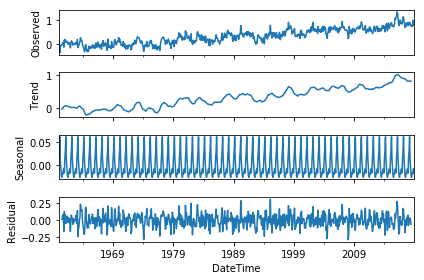

In [72]:
#https://stackoverflow.com/questions/26470570/seasonal-decomposition-of-time-series-by-loess-with-python
decomposition = sm.tsa.seasonal_decompose(glb_range.anomaly)
resplot = decomposition.plot()

### Pick best parameters with auto-arima

Best param with:
Fit ARIMA: order=(3, 1, 1); AIC=-1112.188, BIC=-1084.822

In [62]:
stepwise_fit = pm.auto_arima(glb_range, start_p=1, start_q=1, max_p=5, max_q=5,
                          seasonal=False, d=1, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)  
stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1); AIC=-1084.642, BIC=-1066.398, Fit time=0.163 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-938.555, BIC=-929.433, Fit time=0.005 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-1050.865, BIC=-1037.181, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-1078.190, BIC=-1064.507, Fit time=0.027 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-1114.172, BIC=-1091.367, Fit time=0.408 seconds
Fit ARIMA: order=(2, 1, 0); AIC=-1055.946, BIC=-1037.702, Fit time=0.066 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-1112.152, BIC=-1084.786, Fit time=0.531 seconds
Fit ARIMA: order=(3, 1, 2); AIC=-1111.566, BIC=-1079.639, Fit time=0.907 seconds
Fit ARIMA: order=(3, 1, 1); AIC=-1112.188, BIC=-1084.822, Fit time=0.664 seconds
Total fit time: 2.798 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  707
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 562.086
Method:                       css-mle   S.D. of innovations              0.109
Date:                Tue, 26 Feb 2019   AIC                          -1114.172
Time:                        00:58:46   BIC                          -1091.367
Sample:                             1   HQIC                         -1105.361
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013   7.37e-05     18.233      0.000       0.001       0.001
ar.L1.D.y      0.4799      0.036     13.170      0.000       0.408       0.551
ar.L2.D.y      0.2523      0.037      6.905      0.000       0.181       0.324
ma.L1.D.y     -0.9999      0.007   -151.496      0.000      -1.013      -0.987
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2553           +0.0000j            1.2553            0.0000
AR.2           -3.1569           +0.0000j            3.1569            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

### Predict ARMA-model

In [16]:
mod = sm.tsa.statespace.SARIMAX(glb_range,order=(3,1,1),trend='c', seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  708
Model:               SARIMAX(3, 1, 1)   Log Likelihood                 565.397
Date:                Wed, 27 Feb 2019   AIC                          -1118.794
Time:                        13:57:44   BIC                          -1091.454
Sample:                    01-01-1960   HQIC                         -1108.228
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004   6.19e-05      5.919      0.000       0.000       0.000
ar.L1          0.4690      0.038     12.256      0.000       0.394       0.544
ar.L2          0.2691      0.042      6.340      0.000       0.186       0.352
ar.L3         -0.0096      0.040     -0.243      0.808      -0.087       0.068
ma.L1         -0.9998      0.124     -8.079      0.000      -1.242      -0.757
sigma2         0.0116      0.001      7.772      0.000       0.009       0.015
===================================================================================
Ljung-Box (Q):                       55.18   Jarque-Bera (JB):                 7.63
Prob(Q):                              0.06   Prob(JB):                         0.02
Heteroskedasticity (H):               1.05   Skew:                             0.23
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
prediction = res.get_forecast(steps=373)
pred_ci = prediction.conf_int()
prediction.predicted_mean.tail()

2049-09-01    1.298646
2049-10-01    1.299995
2049-11-01    1.301344
2049-12-01    1.302693
2050-01-01    1.304042
Freq: MS, dtype: float64

In [24]:
pred_ci.tail()

,lower anomaly,upper anomaly
2049-09-01,1.013494,1.583798
2049-10-01,1.014842,1.585147
2049-11-01,1.016191,1.586496
2049-12-01,1.017540,1.587845
2050-01-01,1.018889,1.589194


### Visualize the prediction for temperature anomaly

In [107]:
upper_bound = go.Scatter(
    name='Upper 95% ci',
    x=prediction.predicted_mean.index,
    y=pred_ci['upper anomaly'],
    mode='lines',
    marker=dict(color="#444"),
    line=dict(width=0),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

trace = go.Scatter(
    name='°C',
    x=prediction.predicted_mean.index,
    y=prediction.predicted_mean,
    mode='lines',
    line=dict(color='rgb(58, 178, 255)'),
    fillcolor='rgba(68, 68, 68, 0.3)',
    fill='tonexty')

lower_bound = go.Scatter(
    name='Lower 95% ci',
    x=prediction.predicted_mean.index,
    y=pred_ci['lower anomaly'],
    marker=dict(color="#444"),
    line=dict(width=0),
    mode='lines')

anomaly_measured = go.Scatter(
    name='°C',
    x=glb_range.anomaly.index,
    y=glb_range.anomaly,
    marker=dict(color='rgb(58, 178, 255)'),
    mode='lines')

smoothed_trend = go.Scatter(
    name='Trend °C',
    x=decomposition.trend.index,
    y=decomposition.trend,
    marker=dict(color='rgb(0, 15, 237)'),
    mode='lines')


data = [lower_bound, trace, upper_bound,anomaly_measured,smoothed_trend]

#tighter margins for mobile devices
layout = go.Layout(
    yaxis=dict(title='Temperature Anomaly °C'),
    title='Projected change in Land-Ocean Temperature Index',
    showlegend = False,
    margin=go.layout.Margin(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=0
    ))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='docs/prediction-excersise4.html')
py.plot(fig, filename='prediction-excersise4.html')

'file://C:\\Users\\Simo\\Projects\\personal\\reaktor-summer-2019\\prediction-excersise4.html'